# Modelos de Regresión Logística

### 1. y 2. Creación de variables dicotómicas (precio)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Cargar el dataset
df = pd.read_csv("../data/train_preprocessed.csv")

# Crear columna de categoría de precio según percentiles 33% y 66%
p33 = df['SalePrice'].quantile(0.33)
p66 = df['SalePrice'].quantile(0.66)

def clasificar_precio(precio):
    if precio <= p33:
        return 'economica'
    elif precio <= p66:
        return 'media'
    else:
        return 'cara'

df['categoria_precio'] = df['SalePrice'].apply(clasificar_precio)

# Variables dicotómicas
df['es_cara'] = (df['categoria_precio'] == 'cara').astype(int)
df['es_media'] = (df['categoria_precio'] == 'media').astype(int)
df['es_economica'] = (df['categoria_precio'] == 'economica').astype(int)

# Verificar
df[['SalePrice', 'categoria_precio', 'es_cara', 'es_media', 'es_economica']].head()

,SalePrice,categoria_precio,es_cara,es_media,es_economica
0,208500,cara,1,0,0
1,181500,media,0,1,0
2,223500,cara,1,0,0
3,140000,media,0,1,0
4,250000,cara,1,0,0


### 3. Predecir si una vivienda es cara

Accuracy promedio (cross-validation): 0.9118154139613367


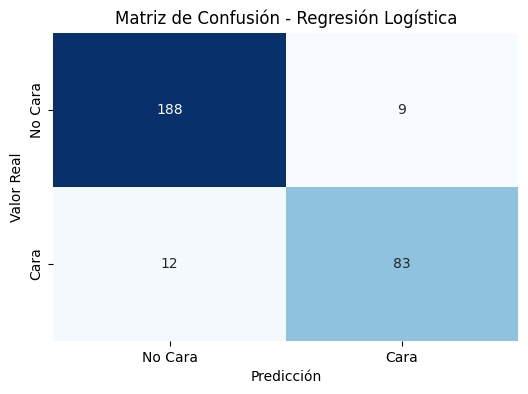


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       197
           1       0.90      0.87      0.89        95

    accuracy                           0.93       292
   macro avg       0.92      0.91      0.92       292
weighted avg       0.93      0.93      0.93       292



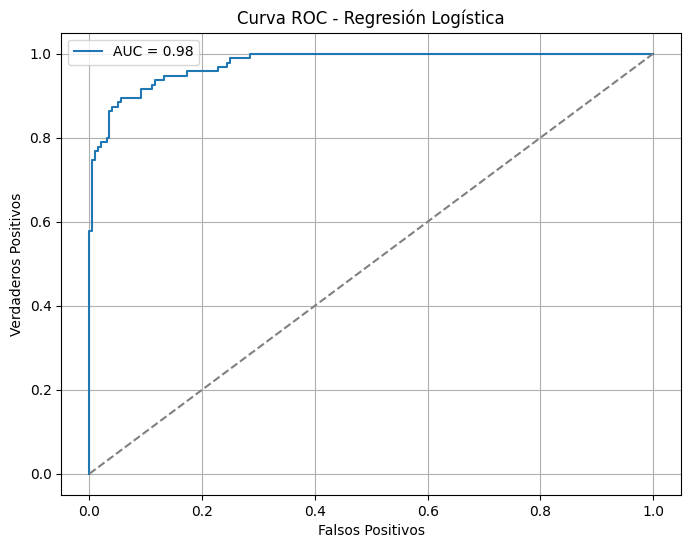

In [8]:
# Seleccionar las variables predictoras y la variable objetivo
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
target = 'es_cara'

# Dividir el dataset (80% entrenamiento, 20% prueba)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión logística
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Validación cruzada
cv_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=5)
print("Accuracy promedio (cross-validation):", cv_scores.mean())

# Predicciones en el conjunto de prueba
y_pred = log_model.predict(X_test_scaled)

# Matriz de confusión visual (heatmap)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Cara', 'Cara'], yticklabels=['No Cara', 'Cara'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Evaluación del modelo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Curva ROC
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid()
plt.show()


###  4. Multicolinealidad, significancia y correlaciones

=== VIF de las variables predictoras ===
      Variable       VIF
0  OverallQual  2.445301
1    GrLivArea  2.474593
2   GarageCars  1.829365
3  TotalBsmtSF  1.556815
4     FullBath  2.099818
5    YearBuilt  2.065456
Optimization terminated successfully.
         Current function value: 0.249285
         Iterations 8

=== Resumen del modelo (statsmodels) ===
                           Logit Regression Results                           
Dep. Variable:                es_cara   No. Observations:                 1168
Model:                          Logit   Df Residuals:                     1161
Method:                           MLE   Df Model:                            6
Date:                Wed, 09 Apr 2025   Pseudo R-squ.:                  0.6128
Time:                        12:49:40   Log-Likelihood:                -291.16
converged:                       True   LL-Null:                       -751.92
Covariance Type:            nonrobust   LLR p-value:                8.394e-196
        

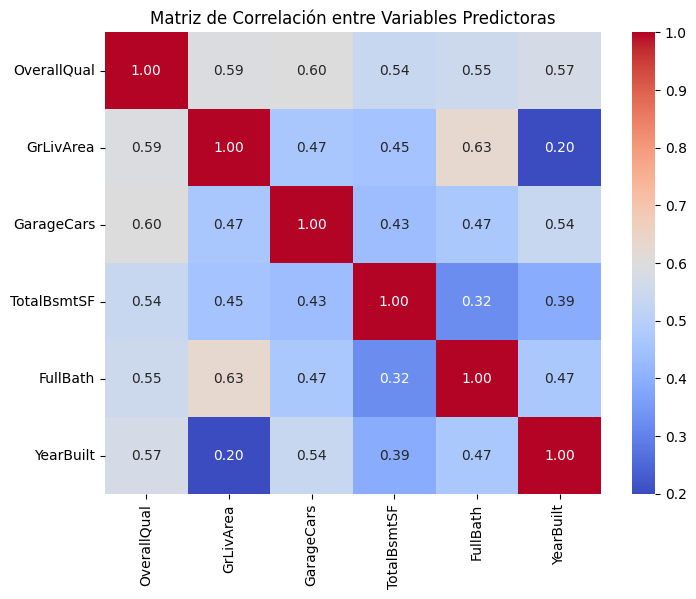

In [9]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF para las variables predictoras
X_vif = pd.DataFrame(X_train_scaled, columns=features)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("=== VIF de las variables predictoras ===")
print(vif_data)

# Entrenar modelo con statsmodels para análisis de significancia
X_const = sm.add_constant(X_train_scaled)  # Agregar término constante (intercepto)
logit_model = sm.Logit(y_train, X_const)
result = logit_model.fit()

print("\n=== Resumen del modelo (statsmodels) ===")
print(result.summary())

# Visualizar matriz de correlación entre las variables predictoras
plt.figure(figsize=(8, 6))
sns.heatmap(X[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Predictoras')
plt.show()